In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import sklearn.preprocessing as preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, BayesianRidge
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import roc_auc_score
one_day = 4547368124071.8799
startt = 9631916820392676.0
delta = 2.16e10
cutoff = 1.5e8


In [ ]:
! pip install -q kaggle
from google.colab import drive
drive.mount('/content/drive')
! mkdir /root/.kaggle
!cp drive/MyDrive/kaggle.json /root/.kaggle/kaggle.json
! chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c facebook-recruiting-iv-human-or-bot
! mkdir train
! unzip /content/facebook-recruiting-iv-human-or-bot.zip -d train

Mounted at /content/drive
 96% 238M/249M [00:03<00:00, 90.2MB/s]
100% 249M/249M [00:03<00:00, 82.7MB/s]
Archive:  /content/facebook-recruiting-iv-human-or-bot.zip
  inflating: train/bids.csv.zip      
  inflating: train/sampleSubmission.csv  
  inflating: train/test.csv.zip      
  inflating: train/train.csv.zip     


In [ ]:
def load(bot_or_human, test,bids ):
	# bot_or_human = pd.read_csv('train.csv')
	# test = pd.read_csv('test.csv')
	test['outcome'] = -1


	# bids = pd.read_csv('bids.csv')
	bids = bids.sort_values(['auction', 'time'])

	bot_or_human = pd.concat([ bot_or_human, test ])

	#strip the last five characters from the address and payment accounts
	bot_or_human.address = bot_or_human.address.apply(address_strip)
	bot_or_human.payment_account = bot_or_human.payment_account.apply(address_strip)


	'''
	pivot bidder address prefix and bidder payment_account prefix into features
	'''
	bot_or_human['payment_account_prefix_same_as_address_prefix'] = bot_or_human['address']==bot_or_human['payment_account']
	max_relevant = 6

	b = bot_or_human[['bidder_id', 'address']].groupby('address').size().reset_index().sort_values(0, ascending=False)
	b = b.rename(columns = {0:'address_count'})
	#repeat_addresses = b[b.address_count >= max_relevant].address.values
	infrequent_addresses = b[b.address_count >= 2][b.address_count < max_relevant].address.values
	rare_addresses = b[b.address_count < 2].address.values
	bot_or_human['address'].loc[bot_or_human.address.isin(rare_addresses)] = 'rare_address'
	bot_or_human['address'].loc[bot_or_human.address.isin(infrequent_addresses)] = 'infrequent_address'
	#b = bot_or_human[['bidder_id', 'address']].pivot(index='bidder_id',columns='address').fillna(0).reset_index()
	b = pd.get_dummies(bot_or_human[['address']])
	bot_or_human = pd.concat([bot_or_human, b], axis=1)

	b = bot_or_human[['bidder_id', 'payment_account']].groupby('payment_account').size().reset_index().sort_values(0, ascending=False)
	b = b.rename(columns = {0:'payment_account_count'})
	#repeat_payment_accounts = b[b.payment_account_count >= max_relevant].payment_account.values
	infrequent_payment_account = b[b.payment_account_count >= 2][b.payment_account_count < max_relevant].payment_account.values
	rare_payment_account = b[b.payment_account_count < 2].payment_account.values
	bot_or_human['payment_account'].loc[bot_or_human.payment_account.isin(rare_payment_account)] = 'rare_account'
	bot_or_human['payment_account'].loc[bot_or_human.payment_account.isin(infrequent_payment_account)] = 'infrequent_account'
	#bot_or_human['payment_account'].loc[~bot_or_human.payment_account.isin(repeat_payment_accounts)] = 'only_once'
	b = pd.get_dummies(bot_or_human[['payment_account']])
	bot_or_human = pd.concat([bot_or_human, b], axis=1)


	return bids, bot_or_human

In [ ]:
def address_strip(x):
	return x[0:-5]

In [ ]:
def dt(X, bids):
	bots = X[X.outcome==1].bidder_id.values
	humans = X[X.outcome==0].bidder_id.values

	'''
	auction duration
	check if auctions run longer than three days
	calculate time from bid until time of last bid in the auction
	calculate time from bid until time of first bid in the auction
	'''
	times = bids.groupby('auction').time.min().reset_index()
	times=times.rename(columns = {'time':'startt'})
	times2 = bids.groupby('auction').time.max().reset_index()
	times2=times2.rename(columns = {'time':'endt'})

	times = pd.merge(times, times2, on='auction', how='left')
	times['duration'] = times.endt - times.startt
	times['short'] = 1.0*(times['duration'] < 3.01*one_day)

	bids = pd.merge(bids, times[['auction', 'short', 'startt', 'endt']], on='auction', how='left')
	b = bids.groupby('bidder_id').short.mean().reset_index()
	X = pd.merge(X, b, on='bidder_id', how='left')

	#time from bid until end of auction
	bids['t_until_end'] = bids.endt - bids.time
	bids['t_since_start'] = bids.time - bids.startt

	b = bids.groupby('bidder_id').t_until_end.median().reset_index()
	b=b.rename(columns = {'t_until_end':'t_until_end_median'})
	X = pd.merge(X, b, on='bidder_id', how='left')

	b = bids.groupby('bidder_id').t_since_start.median().reset_index()
	b=b.rename(columns = {'t_since_start':'t_since_start_median'})
	X = pd.merge(X, b, on='bidder_id', how='left')


	'''
	Useful plots

	test_ids = X[X.outcome==-1].bidder_id.values

	bot = bids[bids.bidder_id.isin(bots)][bids.country.isin(['de', 'nl', 'se', 'no', 'cz', 'hu'])].t_until_end
	human = bids[bids.bidder_id.isin(humans)][bids.country.isin(['de', 'nl', 'se', 'no', 'cz', 'hu'])].t_until_end

	bot = bids[bids.bidder_id.isin(bots)][bids.country.isin(['id'])].t_until_end
	human = bids[bids.bidder_id.isin(humans)][bids.country.isin(['id'])].t_until_end

	bot = bids[bids.bidder_id.isin(bots)].t_until_end
	human = bids[bids.bidder_id.isin(humans)].t_until_end
	botp = np.histogram(bot, 800, range=[0,8e13], normed=True)
	humanp = np.histogram(human, 800, range=[0,8e13], normed=True)

	bot = np.mod(bids[bids.bidder_id.isin(bots)].t_until_end.values, 4.55e12)
	human = np.mod(bids[bids.bidder_id.isin(humans)].t_until_end.values, 4.55e12)

	botp = np.histogram(bot, 300, range=[0,4.9e12], normed=True)
	humanp = np.histogram(human, 300, range=[0,4.9e12], normed=True)

	plt.plot(botp[1][0:-1], botp[0], 'b.-')
	plt.plot(botp[1][0:-1], humanp[0], 'g.-')



	bot = bids[bids.bidder_id.isin(bots)].time
	human = bids[bids.bidder_id.isin(humans)].time
	test = bids[bids.bidder_id.isin(test_ids)].time

	bot = bids[bids.bidder_id.isin(bots)][bids.country.isin(['nl'])].time
	human = bids[bids.bidder_id.isin(humans)][bids.country.isin(['nl'])].time

	bots = ['5354c02817e47f28e60e44a40ca5e48dll4sz']
	humans = ['ff58ffde976a4899dcd89597a7877e18lntgz']

	bot = np.mod(bids[bids.bidder_id.isin(bots)].time.values, one_day)
	human = np.mod(bids[bids.bidder_id.isin(humans)].time.values, one_day)
	humanp = np.histogram(human, 48, range=[0, one_day], normed=True)
	botp = np.histogram(bot, 48, range=[0, one_day], normed=True)


	humanp = np.histogram(human, 4000, range=[9.63e15, 9.78e15], normed=True)
	botp = np.histogram(bot, 4000, range=[9.63e15, 9.78e15], normed=True)
	testp = np.histogram(test, 4000, range=[9.63e15, 9.78e15], normed=True)

	humanp = np.histogram(human, 30, range=[9.63e15, 9.9e15], normed=True)
	botp = np.histogram(bot, 30, range=[9.63e15, 9.9e15], normed=True)


	humanp = np.histogram(human, 1000, range=[9.631e15, 9.645e15], normed=True)
	botp = np.histogram(bot, 1000, range=[9.631e15, 9.645e15], normed=True)

	plt.plot(humanp[1][0:-1], testp[0], 'r.-')
	plt.plot(humanp[1][0:-1], humanp[0], 'g.-')
	plt.plot(humanp[1][0:-1], botp[0], 'b.-')
	plt.ylabel('fraction of bids made between t and t+dt')
	plt.xlabel('time [arbitrary units]')
	plt.legend(['human','bot'], frameon=False)
	plt.title('bids over time')
	plt.show()

	dt = humanp[1][1] - humanp[1][0]
	a = np.correlate(humanp[0], humanp[0], mode='full')
	plt.plot(dt*np.array(range(0,len(a)-len(a)/2)), a[len(a)/2:], 'k.-')
	plt.ylabel('autocorrelation')
	plt.xlabel('time')
	plt.title('autocorrelation of bids/unit time histogram')

	#sample bids per unit time over an auction
	plt.hist(bids[bids.auction == bids.auction[3]].time.values, bins=200)
	plt.ylabel('bids')
	plt.xlabel('time')
	plt.title('bids during auction')
	'''


	'''
	number of bids per hour (n=24), half hour (n=48)
	'''
	times = [72]
	for n in times:
		print('hour ', n)
		b = np.floor((1.0*n/one_day*np.mod(bids.time-startt-delta, one_day)))
		b.name = 'hour'+str(n)
		bids = pd.concat([bids, b], axis=1)
		b = bids.groupby(['bidder_id', 'hour'+str(n)]).size().reset_index()
		b=b.rename(columns = {0:'bids_in_hour'})
		b=b.pivot('bidder_id', 'hour'+str(n), 'bids_in_hour').fillna(0).reset_index()
		old_names = b.columns.values
		new_names = b.columns.values
		for i in range(1,len(b.columns)):
			new_names[i] = str(int(old_names[i])) + '_hour'+str(n)
		b = b.rename(columns=dict(zip(old_names, new_names)))
		b['max_bids_in_hour'+str(n)] = b.iloc[:, 1:].max(axis=1)

		for i in range(n):
			b[str(i)+'_hour'+str(n)] = b[str(i)+'_hour'+str(n)]/b['max_bids_in_hour'+str(n)]
		#b = b.drop('max_bids_in_hour'+str(n), 1)
		X = pd.merge(X, b, on='bidder_id', how='left')

	n = times[0]
	X['sleep'] = 0
	step = int(5.5*n/24)
	for i in range(n - step):
		X['sleep'] += X.loc[:, str(i)+'_hour'+str(n):str(i+step)+'_hour'+str(n)].sum(axis=1) == 0

	X['sleep'] = (X['sleep'] >= 1)


	'''
	dt between a user's bid and the previous bid by another user in the same auction
	'''
	for week in [0, 2, 4]:
		b = bids[bids.week==week].sort_values(['auction', 'time'])[['auction', 'time', 'bidder_id']]
		b['bidder_id_prev'] = pd.Series(np.append([np.nan], b.bidder_id.values[0:-1]), index=b.index)
		b['auction_prev'] = pd.Series(np.append([np.nan], b.auction.values[0:-1]), index=b.index)
		dt = np.append([np.nan], b.time.values[0:-1])
		b['time_prev'] = pd.Series(dt, index=b.index)
		b['dt'] = b['time'] - b['time_prev']

		if week==0:
			c = [b[b.bidder_id != b.bidder_id_prev][b.auction == b.auction_prev]]
		else:
			c.append(b[b.bidder_id != b.bidder_id_prev][b.auction == b.auction_prev])

	c = pd.concat(c)
	d = c.groupby('bidder_id').dt.median().reset_index()
	d = d.rename(columns = {'dt': 'dt_others_median'})
	X = pd.merge(X, d[['bidder_id', 'dt_others_median']], on='bidder_id', how='left')
	#X.loc[:,'dt_others_median'] = X.loc[:,'dt_others_median'].fillna(3.0*one_day)

	c['dt_others_lt_cutoff'] = np.nan
	c.loc[c.dt <= cutoff, 'dt_others_lt_cutoff'] = 1.0
	c.loc[c.dt > cutoff, 'dt_others_lt_cutoff'] = 0.0

	a= c[['bidder_id', 'dt_others_lt_cutoff']].dropna().groupby('bidder_id').mean().reset_index()
	X = pd.merge(X, a, on='bidder_id', how='left')
	X=X.rename(columns = {'dt_others_lt_cutoff':'f_dt_others_lt_cutoff'})

	#plt.hist(X[X.outcome==0].dt_median.values, bins=100, range=[0, 1e9], normed=True)
	#plt.hist(X[X.outcome==1].dt_median.values, bins=100, range=[0, 1e9], normed=True)



	#time between bids by same bidder (does not matter if previous bid is in same auction)
	for week in [0, 2, 4]:
		b = bids[bids.week==week].sort_values(['bidder_id', 'time'])[['bidder_id', 'time']]
		#b['bidder_id_prev'] = np.nan
		#b.bidder_id_prev[1:] = b.bidder_id[0:-1]
		b['bidder_id_prev'] = pd.Series(np.append([np.nan], b.bidder_id.values[0:-1]), index=b.index)

		#b['time_prev'] = np.nan
		dt = np.append([np.nan], b.time.values[0:-1])
		b['time_prev'] = pd.Series(dt, index=b.index)
		b['dt'] = b['time'] - b['time_prev']


		if week==0:
			c = [b[b.bidder_id == b.bidder_id_prev]]
		else:
			c.append(b[b.bidder_id == b.bidder_id_prev])

	c = pd.concat(c)
	d = c.groupby('bidder_id').dt.median().reset_index()
	d = d.rename(columns = {'dt': 'dt_self_median'})
	X = pd.merge(X, d[['bidder_id', 'dt_self_median']], on='bidder_id', how='left')
	d = c.groupby('bidder_id').dt.min().reset_index()
	d = d.rename(columns = {'dt': 'dt_self_min'})
	X = pd.merge(X, d[['bidder_id', 'dt_self_min']], on='bidder_id', how='left')
	#X.loc[:,'dt_self_median'] = X.loc[:,'dt_self_median'].fillna(3.0*one_day)
	#X.loc[:,'dt_self_min'] = X.loc[:,'dt_self_min'].fillna(3.0*one_day)


	'''
	bot_h = np.histogram(bids[bids.bidder_id.isin(bots)].dt.values, bins=100, range=[0, 1e10], normed=True)
	human_h = np.histogram(bids[bids.bidder_id.isin(humans)].dt.values, bins=100, range=[0, 1e10], normed=True)
	plt.plot(bot_h[1][1:], bot_h[0], 'b.-')
	plt.plot(bot_h[1][1:], human_h[0], 'r.-')
	'''



	return X

In [ ]:
def n_bids(X, bids):
	a = bids.groupby(['bidder_id', 'auction']).size().reset_index()
	a=a.rename(columns = {0:'bids_per_auction'})
	b = a.groupby('bidder_id').bids_per_auction.median().reset_index()
	b=b.rename(columns = {'bids_per_auction':'bids_per_auction_median'})
	X = pd.merge(X, b, on='bidder_id', how='left')

	b = a.groupby('bidder_id').mean().reset_index()
	b=b.rename(columns = {'bids_per_auction':'bids_per_auction_mean'})
	X = pd.merge(X, b, on='bidder_id', how='left')

	b = bids.groupby('bidder_id').size().reset_index()
	b=b.rename(columns = {0:'n_bids'})
	X = pd.merge(X, b, on='bidder_id', how='left')

	return X

In [ ]:
def enumerate(x):
	x['bid_order'] = 1.0*np.arange(len(x))/len(x)
	return x


def fac_div_fac(x,y):

	if x == 0:
		x = 1
	if y == 0:
		y = 1

	if x > y:
		return np.sum( np.log(1.0*np.array(range(int(y+1),int(x+1))) ) )
	if y > x:
		return -np.sum( np.log(1.0*np.array(range(int(x+1),int(y+1))) ) )
	return 0.0

In [ ]:
def balance(x):
#	x['balance'] = np.std(x)/np.sqrt(np.mean(x))

	x0 = int(np.floor(np.sum(x)/len(x)))
	base = x0*np.ones(len(x))
	base[0:int(np.sum(x)-x0*len(x))] = x0+1

	b = 0.0
	for i in range(len(x)):
		#print base[i], x[i]
		b += fac_div_fac(base[i], x[i])

	#print b
	x['balance'] = b

	return x

In [ ]:
def day(X, bids):
	bots = X[X.outcome==1].bidder_id.values
	humans = X[X.outcome==0].bidder_id.values

	bids['day'] = np.floor((bids['time'] - startt)/one_day)

	b = bids.groupby(['bidder_id', 'day']).size().reset_index()
	b = b.rename(columns = {0:'daily_bids'})
	b = b.pivot('bidder_id', 'day', 'daily_bids').fillna(0).reset_index()
	old_names = b.columns.values
	new_names = [b.columns[0]]
	for i in range(1,len(b.columns)):
		new_names.append( str(int(old_names[i])) + '_day' )
	b = b.rename(columns=dict(zip(old_names, new_names)))


	b['monday'] = (b['0_day'] + b['14_day'] + b['28_day']).fillna(0)
	b['tuesday'] = (b['1_day'] + b['15_day'] + b['29_day']).fillna(0)
	b['wednesday'] = (b['2_day'] + b['16_day'] + b['30_day']).fillna(0)
	b['balance'] = b[['monday', 'tuesday', 'wednesday']].apply(balance, axis=1)[['balance']]
	b['balance2'] = b[['0_day', '1_day', '2_day', '14_day', '15_day', '16_day', '28_day', '29_day', '30_day']].apply(balance, axis=1)[['balance']]

	X = pd.merge(X, b.loc[:,['bidder_id', 'monday', 'tuesday', 'wednesday', 'balance', 'balance2']], on='bidder_id', how='left')
	X[['monday', 'tuesday', 'wednesday', 'balance']] = X[['monday', 'tuesday', 'wednesday', 'balance']].fillna(0)

	s = X.loc[:, ['monday', 'tuesday', 'wednesday']].max(axis=1)
	X['s_monday'] = X['monday']/s
	X['s_tuesday'] = X['tuesday']/s
	X['s_wednesday'] = X['wednesday']/s

	s = X.loc[:, ['monday', 'tuesday', 'wednesday']].sum(axis=1)
	X['f_monday'] = X['monday']/s
	X['f_tuesday'] = X['tuesday']/s
	X['f_wednesday'] = X['wednesday']/s

# 	nbids = X.loc[:, ['monday', 'tuesday', 'wednesday']].sum(axis=1)
# 	X['bids_week0'] = (b['0_day'] + b['1_day'] + b['2_day']).fillna(0)
# 	X['bids_week2'] = (b['14_day'] + b['15_day'] + b['16_day']).fillna(0)
# 	X['bids_week4'] = (b['28_day'] + b['29_day'] + b['30_day']).fillna(0)
# 	s = X.loc[:, ['bids_week0', 'bids_week2', 'bids_week4']].max(axis=1)
# 	X['s_bids_week0'] = X['bids_week0']/s
# 	X['s_bids_weeek2'] = X['bids_week2']/s
# 	X['s_bids_week4'] = X['bids_week4']/s

	X.drop('balance2', 1, inplace=True)

	return X

In [ ]:
def bid_order(X, bids):
	bids = bids.groupby('auction').apply(enumerate)

	a = bids.sort_values('time', ascending=True).groupby('auction', as_index=False).first()
	b = a.groupby('bidder_id').size().reset_index()
	b= b.rename(columns = {0:'num_first_bid'})
	X = pd.merge(X, b, on='bidder_id', how='left')
	print(X.columns)
	X['num_first_bid'].fillna(0, inplace=True)


	return X

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def user_countries_per_auction(X, bids):
	#a = bids.groupby(['auction', 'bidder_id', 'country']).country.count()
	#a = bids.groupby(['auction', 'bidder_id']).country.size()
	#bids[bids.bidder_id=='5c28b04424e96267711d5af2db62e022tp36c'][['auction', 'country']].groupby('auction').size()


	b = bids[['bidder_id', 'auction', 'country']].groupby(['bidder_id','auction']).country.nunique().reset_index()
	b= b.rename(columns = {'country':'countries_per_bidder_per_auction'})


	c = b.groupby('bidder_id').countries_per_bidder_per_auction.median().reset_index()
	c= c.rename(columns = {'countries_per_bidder_per_auction':'countries_per_bidder_per_auction_median'})
	X = pd.merge(X, c, on='bidder_id', how='left')

	c = b.groupby('bidder_id').countries_per_bidder_per_auction.mean().reset_index()
	c= c.rename(columns = {'countries_per_bidder_per_auction':'countries_per_bidder_per_auction_mean'})
	X = pd.merge(X, c, on='bidder_id', how='left')

	c = b.groupby('bidder_id').countries_per_bidder_per_auction.max().reset_index()
	c= c.rename(columns = {'countries_per_bidder_per_auction':'countries_per_bidder_per_auction_max'})
	X = pd.merge(X, c, on='bidder_id', how='left')

	# a = bids.groupby(['bidder_id']).country.value_counts()
	# b = a.groupby(['bidder_id']).agg(lambda x: x.iloc[0]).reset_index()
	# b = b.rename(columns = {'level_1':'most_common_country'})
	# X = pd.merge(X, b[['bidder_id','most_common_country']], on='bidder_id', how='left')

	b = bids[['bidder_id', 'country']].groupby(['bidder_id', 'country']).size().reset_index()
	b= b.rename(columns = {0:'nbids'})
	c = b.pivot('bidder_id','country').fillna(0).reset_index()
	c.columns = c.columns.get_level_values(1)
	c= c.rename(columns={c.columns[0]:'bidder_id'})
	#fraction of bids in each country (for each user)
	#c.iloc[:,1:] = c.iloc[:,1:].div(c.iloc[:,1:].sum(axis=1), axis=0)
	#number of bids in each country rescaled by the largest number of bids in a country (for each user)
	c.iloc[:,1:] = c.iloc[:,1:].div(c.iloc[:,1:].max(axis=1), axis=0)
	X = pd.merge(X, c, on='bidder_id', how='left')


	#b = bids[['bidder_id', 'country']].groupby(['bidder_id', 'country']).country.nunique().reset_index()
	#b = bids[['bidder_id', 'country']].groupby(['bidder_id', 'country']).size().reset_index()



# 	a = bids.groupby(['bidder_id', 'country']).size().reset_index()
# 	a= a.rename(columns = {0:'c_count'})
# 	a.groupby(['bidder_id']).sort('c_count').agg(lambda x: x.iloc[0])
#
# 	a = bids.groupby(['bidder_id']).country.apply(mode())
# 	a= a.rename(columns = {0:'bids_in_country'})
# 	a.groupby(['bidder_id']).agg(lambda x:x.value_counts())

	#bids[bids.bidder_id=='0053b78cde37c4384a20d2da9aa4272aym4pb'][bids.auction=='1l3p3'][['time', 'country']]

# 	hum = np.histogram(X[X.outcome==0].countries_per_bidder_per_auction_max.values, bins=10, normed=True, range=[0,10])
# 	bot = np.histogram(X[X.outcome==1].countries_per_bidder_per_auction_max.values, bins=10, normed=True, range=[0,10])
# 	plt.plot(hum[1][0:-1], hum[0], 'g.-')
# 	plt.plot(hum[1][0:-1], bot[0], 'b.-')

	return X

In [ ]:
def log_entropy(x):
	e = np.sum(np.log(np.array(range(1,np.sum(x)))))
	for i in x:
		e -= np.sum(np.log(np.array(range(1,i))))

	return e

In [ ]:
def urls(X, bids):
	'''
	number of unique referring urls used by bidder
	unique referring urls / total_bids
	'''
	b = bids.groupby('bidder_id').url.nunique().reset_index().fillna(1)
	b= b.rename(columns = {'url':'n_urls'})
	X = pd.merge(X, b, on='bidder_id', how='left')
	b = bids.groupby(['bidder_id']).url.count().reset_index().fillna(1)
	b= b.rename(columns = {'url':'n_bids_url'})
	X = pd.merge(X, b, on='bidder_id', how='left')
	X['f_urls'] = X['n_urls']/X['n_bids_url']

	nbids =bids.groupby(['bidder_id']).size().reset_index()
	nbids= nbids.rename(columns = {0:'nbids'})

	a =bids.groupby(['bidder_id', 'url']).size().reset_index()
	a= a.rename(columns = {0:'url_counts'})
	a['urls_used'] = 1.0


	a = pd.merge(a, nbids, on='bidder_id', how='left')
	a['f_urls'] = a['url_counts']/a['nbids']

	b = a.groupby('url').urls_used.count().reset_index()
	print('num urls ', b[b.urls_used > 18].url.values.shape[0])

	repeat_urls = b[b.urls_used > 18].url.values

	c = a[a.url.isin(repeat_urls)].pivot('bidder_id','url','f_urls').reset_index()
	X = pd.merge(X, c, on='bidder_id', how='left')
	X.iloc[:, -len(repeat_urls):] = X.iloc[:, -len(repeat_urls):].fillna(0)

	b = bids.groupby(['bidder_id', 'url']).size().reset_index()
	b= b.rename(columns = {0:'url_count'})
	c = b.groupby('bidder_id').url_count.apply(log_entropy).reset_index()
	c= c.rename(columns = {'url_count':'url_entropy'})

	X = pd.merge(X, c, on='bidder_id', how='left')

	X['f_urls'].fillna(1.0)

	return X

In [ ]:
def merch(X, bids):
	'''
	type of merchandise on first page visited by bidder
	'''
	a = bids.groupby('bidder_id').first().reset_index()
	b = pd.get_dummies(a['merchandise'], columns='merchandise')
	X = pd.concat([X, b], axis=1)

	return X

In [ ]:
def ip(X,bids):
	bots = list(X[X.outcome==1].bidder_id.values)
	humans = list(X[X.outcome==0].bidder_id.values)



	'''
	IP fingerprint
	uses a clustering algorithm to group bidders which use a similar set of IPs
	it's quite time consuming
	'''
	'''
	nbids = bids.groupby('bidder_id').size().reset_index()
	nbids= nbids.rename(columns = {0:'n_bids'})

	b = bids[bids.bidder_id.isin(bots+humans)].groupby('ip').bidder_id.nunique().reset_index()
	ip_many_users = b[b.bidder_id >= 2].ip.values
	c = bids[bids.bidder_id.isin(bots+humans)].loc[bids.ip.isin(ip_many_users), :].groupby(['bidder_id', 'ip']).size().reset_index()
	#c['v'] = 1
	c= c.rename(columns = {0:'counts'})
	c = pd.merge(c, nbids, on='bidder_id', how='left')
	c['f'] = c['counts']/c['n_bids']
	d = c.pivot('bidder_id', 'ip', 'f').reset_index().fillna(0)
	print 'starting clustering'
	brc = MiniBatchKMeans(n_clusters=100, init='k-means++', max_iter=100, batch_size=100, verbose=0, compute_labels=True, random_state=None, tol=0.0, max_no_improvement=10, init_size=None, n_init=3, reassignment_ratio=0.01)
	brc.fit(d.values[:, 1:])

	c = bids.loc[bids.ip.isin(ip_many_users), :].groupby(['bidder_id', 'ip']).size().reset_index()
	c['v'] = 1
	d = c.pivot('bidder_id', 'ip', 'v').reset_index().fillna(0)
	clusters = brc.predict(d.values[:, 1:])
	print 'done clustering'

	e = d[['bidder_id']]
	e['ip_cluster'] = np.nan
	e.loc[:,['ip_cluster']] = pd.Series(clusters, index=e.index)


	X= pd.merge(X, e[['bidder_id', 'ip_cluster']], on='bidder_id', how='left')
	X['ip_cluster'].fillna(-1, inplace=True)
	y = pd.get_dummies(X['ip_cluster'])
	print 'ip groupings size ', y.shape[1]
	X = X.join(y)
	X = X.drop('ip_cluster', 1)

	print 'done ip fingerprint'
	'''



	'''
	ips per auction for each bidder
	'''
	a = bids[['bidder_id', 'auction', 'ip']].groupby(['bidder_id','auction', 'ip']).size().reset_index()
	a= a.rename(columns = {0:'bids_per_auction_per_ip'})
	b = a.groupby(['bidder_id', 'auction']).bids_per_auction_per_ip.apply(log_entropy).reset_index()
	b= b.rename(columns = {'bids_per_auction_per_ip':'bids_per_auction_per_ip_entropy'})
	c = b.groupby('bidder_id').bids_per_auction_per_ip_entropy.median().reset_index()
	c= c.rename(columns = {'bids_per_auction_per_ip_entropy':'bids_per_auction_per_ip_entropy_median'})
	X = pd.merge(X, c[['bidder_id','bids_per_auction_per_ip_entropy_median' ]], on='bidder_id', how='left')
	c = b.groupby('bidder_id').bids_per_auction_per_ip_entropy.mean().reset_index()
	c= c.rename(columns = {'bids_per_auction_per_ip_entropy':'bids_per_auction_per_ip_entropy_mean'})
	X = pd.merge(X, c[['bidder_id','bids_per_auction_per_ip_entropy_mean' ]], on='bidder_id', how='left')

	b = bids[['bidder_id', 'auction', 'ip']].groupby(['bidder_id','auction']).ip.nunique().reset_index()
	b= b.rename(columns = {'ip':'ips_per_bidder_per_auction'})
# 	b = pd.merge(b,a, on=['bidder_id', 'auction'], how='left')
# 	b['f_ips_per_bidder_per_auction'] = b['ips_per_bidder_per_auction']/b['bids_per_auction']

	c = b.groupby('bidder_id').ips_per_bidder_per_auction.median().reset_index()
	c= c.rename(columns = {'ips_per_bidder_per_auction':'ips_per_bidder_per_auction_median'})
	X = pd.merge(X, c[['bidder_id', 'ips_per_bidder_per_auction_median']], on='bidder_id', how='left')
	c = b.groupby('bidder_id').ips_per_bidder_per_auction.mean().reset_index()
	c= c.rename(columns = {'ips_per_bidder_per_auction':'ips_per_bidder_per_auction_mean'})
	X = pd.merge(X, c[['bidder_id', 'ips_per_bidder_per_auction_mean']], on='bidder_id', how='left')

	'''
	fraction of bids placed by user from IP which is rare
	'''
	#b = bids.groupby(['ip', 'bidder_id']).size().reset_index()
	b = bids.groupby('ip').bidder_id.nunique().reset_index()
	ip_many_users = b[b.bidder_id > 1].ip.values
	#ip_some_users = b[b.bidder_id < 300].ip.values
	#ip_few_users = b[b.bidder_id <= 50].ip.values
	ip_only_one_user = b[b.bidder_id == 1].ip.values

	bids['ip2'] = np.nan
	bids.loc[bids.ip.isin(ip_many_users), ['ip2']] = 'many'
	#bids.loc[bids.ip.isin(ip_some_users), ['ip2']] = 'some'
	#bids.loc[bids.ip.isin(ip_few_users), ['ip2']] = 'few'
	bids.loc[bids.ip.isin(ip_only_one_user), ['ip2']] = 'only_one_user'

	c = bids.groupby(['bidder_id','ip2']).size().reset_index()
	c = c.rename(columns = {0: 'counts'})
	d = c.pivot('bidder_id', 'ip2', 'counts').reset_index().fillna(0)
	d['ip_only_one_user_counts'] = 1*d['only_one_user']
	d.iloc[:,1:] = d.iloc[:,1:].div(d.iloc[:,1:].sum(axis=1), axis=0)
	X = pd.merge(X, d, on='bidder_id', how='left')
	X.iloc[:, -(d.shape[1]-1):].fillna(0, inplace=True)
	X = X.drop('many', 1)
	#X = X.drop('some', 1)
	#X = X.drop('few', 1)
	print('finished building ip pivot table', d.shape[1])


	'''
	does the bidder use a network that has a bot on it? (where the bot is not that bidder)
	what fraction of networks used by the bidder have bots on them? (where the bot is not that bidder)
	'''

	bids = pd.merge(bids, X[['bidder_id', 'outcome']], on='bidder_id', how='left')
	bids['outcome'] = 1.0*(bids['outcome'] == 1)
	b = bids.groupby(['ip', 'bidder_id']).outcome.mean().reset_index()
	b.outcome = 1.0*(b.outcome)
	c = b.groupby('ip').outcome.sum().reset_index()
	c['nbots_on_ip'] = c.outcome
	bids = pd.merge(bids, c[['ip', 'nbots_on_ip']], on='ip', how='left')
	bids['on_ip_that_has_a_bot'] = 1*((bids['nbots_on_ip'] - bids['outcome']) >= 1)
	bids['on_ip_that_has_3bots'] = 1*((bids['nbots_on_ip'] - bids['outcome']) >= 3)
	bids = bids.drop('outcome', 1)
	bids = bids.drop('nbots_on_ip', 1)

	b = bids.groupby(['bidder_id', 'ip']).on_ip_that_has_a_bot.mean().reset_index()
	c = b.groupby('bidder_id').on_ip_that_has_a_bot.mean().reset_index()
	X = pd.merge(X, c[['bidder_id', 'on_ip_that_has_a_bot']], on='bidder_id', how='left')
	X['on_ip_that_has_a_bot_mean'] = X['on_ip_that_has_a_bot'].fillna(0)
	X['on_ip_that_has_a_bot'] = 1*(X['on_ip_that_has_a_bot'].fillna(0) > 0)

#  	b = bids.groupby(['bidder_id', 'ip']).on_ip_that_has_3bots.mean().reset_index()
#  	c = b.groupby('bidder_id').on_ip_that_has_3bots.mean().reset_index()
#  	X = pd.merge(X, c[['bidder_id', 'on_ip_that_has_3bots']], on='bidder_id', how='left')
# 	X['on_ip_that_has_3bots_mean'] = X['on_ip_that_has_3bots'].fillna(0)
# 	X['on_ip_that_has_3bots'] = 1*(X['on_ip_that_has_3bots'].fillna(0) > 0)

	'''
	IP entropy
	'''
	b = bids.groupby(['bidder_id', 'ip']).size().reset_index()
	b= b.rename(columns = {0:'ip_count'})
	c = b.groupby('bidder_id').ip_count.apply(log_entropy).reset_index()
	c= c.rename(columns = {'ip_count':'ip_entropy'})
	X = pd.merge(X, c, on='bidder_id', how='left')



	'''
	time between subsequent bids on different IPs for each user
	'''
	for week in [0, 2, 4]:
		b = bids[bids.week==week].sort_values(['bidder_id', 'time'])[['bidder_id', 'time', 'ip']]
		b['bidder_id_prev'] = pd.Series(np.append([np.nan], b.bidder_id.values[0:-1]), index=b.index)
		b['ip_prev'] = pd.Series(np.append([np.nan], b.ip.values[0:-1]), index=b.index)
		dt = np.append([np.nan], b.time.values[0:-1])
		b['time_prev'] = pd.Series(dt, index=b.index)
		b['dt'] = b['time'] - b['time_prev']

		if week==0:
			c = [b[b.bidder_id == b.bidder_id_prev][b.ip != b.ip_prev]]
		else:
			c.append(b[b.bidder_id == b.bidder_id_prev][b.ip != b.ip_prev])

	c = pd.concat(c)
	d = c.groupby('bidder_id').dt.median().reset_index()
	d = d.rename(columns = {'dt': 'dt_change_ip_median'})
	X = pd.merge(X, d[['bidder_id', 'dt_change_ip_median']], on='bidder_id', how='left')


	'''
	time between bids on the same IP for each user
	'''
	for week in [0, 2, 4]:
		b = bids[bids.week==week].sort_values(['bidder_id', 'time'])[['bidder_id', 'time', 'ip']]
		b['bidder_id_prev'] = pd.Series(np.append([np.nan], b.bidder_id.values[0:-1]), index=b.index)
		b['ip_prev'] = pd.Series(np.append([np.nan], b.ip.values[0:-1]), index=b.index)
		dt = np.append([np.nan], b.time.values[0:-1])
		b['time_prev'] = pd.Series(dt, index=b.index)
		b['dt'] = b['time'] - b['time_prev']

		if week==0:
			c = [b[b.bidder_id == b.bidder_id_prev][b.ip == b.ip_prev]]
		else:
			c.append(b[b.bidder_id == b.bidder_id_prev][b.ip == b.ip_prev])

	c = pd.concat(c)
	d = c.groupby('bidder_id').dt.median().reset_index()
	d = d.rename(columns = {'dt': 'dt_same_ip_median'})
	X = pd.merge(X, d[['bidder_id', 'dt_same_ip_median']], on='bidder_id', how='left')




	#X['dt_change_ip-dt_same_ip'] = X['dt_change_ip_median'] - X['dt_same_ip_median']
	#X.loc[:,'dt_change_ip_median'] = X.loc[:,'dt_change_ip_median'].fillna(30.0*one_day)
	#X.loc[:,'dt_same_ip_median'] = X.loc[:,'dt_same_ip_median'].fillna(30.0*one_day)
	#X.loc[:,'dt_change_ip-dt_same_ip'] = X.loc[:,'dt_change_ip-dt_same_ip'].fillna(30.0*one_day)

	X['dt_change_ip_median'].fillna(-1, inplace=True)
	X['dt_same_ip_median'].fillna(-1, inplace=True)
# 	X['dt_change_ip-dt_same_ip'].fillna(-31*one_day, inplace=True)


	'''
	giant pivot table of overlapping IPs
	'''
	'''
	q = bids[bids.bidder_id.isin(bots+humans)].groupby('ip').bidder_id.nunique().reset_index()
	ip_many_users = q[q.bidder_id >= 3].ip.values

	b = bids.groupby(['ip','bidder_id',]).size().reset_index()
	b = b[b.ip.isin(ip_many_users)]
	b = b.rename(columns = {0:'count'})
	b.drop('count', 1, inplace=True)

	b2 = bids[bids.bidder_id.isin(bots+humans)].groupby(['ip','bidder_id',]).size().reset_index()
	b2 = b2[b2.ip.isin(ip_many_users)]
	b2 = b2.rename(columns = {0:'count'})
	b2.drop('count', 1, inplace=True)

	b2 = b2.rename(columns = {'bidder_id':'bidder_id2'})
	b2['v'] = 1
	c = pd.merge(b,b2, on='ip', how='left')
	d = c.pivot_table(index='bidder_id', columns='bidder_id2', values='v')
	d = d.reset_index().fillna(0)
	X = pd.merge(X, d, on='bidder_id', how='left')
	X.iloc[:, -d.shape[1]-1:].fillna(0, inplace=True)
	print 'finished cluster fingerprint'
	'''


	return X

In [ ]:
def build_X(bids, bot_or_human):
	X = bot_or_human
	X = X.drop('payment_account', 1)
	X = X.drop('address', 1)

	bids['day'] = (np.floor((bids['time'] - startt)/one_day))
	bids['week'] = (np.floor(bids['day']/7.0))

	#print bids.bidder_id[0]
	print('-' * 10,'starting ips','-' * 10)
	X = ip(X, bids)
	print('-' * 10,'starting bid order','-' * 10)
	X = bid_order(X, bids)
	print('-' * 10,'starting dt','-' * 10)
	X = dt(X, bids)
	print('-' * 10,'startin day','-' * 10)
	X = day(X, bids)
	print('-' * 10,'starting n_bids','-' * 10)
	X = n_bids(X,bids)
	print('-' * 10,'starting urls','-' * 10)
	X = urls(X, bids)
	print('-' * 10,'starting countries','-' * 10)
	X = user_countries_per_auction(X, bids)
	print('-' * 10,'starting merch','-' * 10)
	X = merch(X, bids)


	return X

In [ ]:
def mean_over_cols(x):
	s = np.sum(x)
	x['f_bids_first_third'] = x[0]/s
	x['f_bids_second_third'] = x[1]/s
	x['f_bids_third_third'] = x[2]/s
	return x

In [ ]:
def make(X):
	output = X[X.outcome==-1]['bidder_id'].reset_index()
	print(X.shape)
	X.drop(X[X.outcome >=0][X.n_bids.isnull()].index, inplace=True)
	#print(X.shape)

	#X = X.sort(['n_bids', 'dt_others_median'])
	#Weihsin
	X = X.sort_values(['dt_others_median'])
	#X = X.sort(['on_ip_that_has_a_bot_mean', 'dt_others_median'])
	X = X.fillna(method='pad')
#  	X = X.sort(['on_ip_that_has_a_bot_mean'])
#  	X = X.fillna(method='pad')
	X = X.fillna(method='backfill')
	X.sort_index(inplace=True)
	X = X.fillna(0)

	# X = X.drop('most_common_country', 1)
	X = X.drop('bidder_id', 1)

	#clf0 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=4, min_samples_split=2)
	#clf0 = RandomForestClassifier(n_estimators=100, max_depth=4, min_samples_split=2, random_state=0)

	#clf = SGDClassifier(loss="modified_huber", penalty="elasticnet", n_iter=20000, class_weight='auto', alpha=0.1, epsilon=0.01)
	#clf = SVC(C=1.0, class_weight='auto', probability=True, kernel='rbf', gamma=0.0, tol=1e-1)
	#clf = AdaBoostClassifier(n_estimators=3000)
	#clf = GradientBoostingClassifier(n_estimators=3000, learning_rate=0.01, max_depth=None, min_samples_leaf=1)
	#clf = ExtraTreesClassifier(n_estimators=3000, max_depth=None, min_samples_leaf=1, random_state=0)

	#clf = RandomForestClassifier(n_estimators=2500, max_depth=None, min_samples_leaf=1, random_state=0, criterion='entropy')
	clf = []
	nclf = 5
	for i in range(nclf):
		clf.append(RandomForestClassifier(n_estimators=800, max_depth=None, min_samples_leaf=1, random_state=i, criterion='entropy') )

	scores = []
	scores0 = []

	Yb = X['outcome'].values
	Xb = 1.0*X.drop('outcome', 1)

	columns = Xb.columns
	Xb = preprocessing.normalize(Xb.values, axis=0)
	first_test_item = X[X.outcome>=0].shape[0]


	X_test = Xb[first_test_item:, :]
	print('X_test shape ', X_test.shape)
	Y = Yb[0:first_test_item]
	X = Xb[0:first_test_item, :]


	n = int(0.8*X.shape[0])

	all = [i for i in range(X.shape[0])]

	for i in range(100):

		np.random.shuffle(all)
		train = all[0:n]
		valid = all[n:]

		X_train = Xb[train, :]
		X_valid = Xb[valid, :]
		Y_train = Yb[train]
		Y_valid = Yb[valid]



		X_train2 = X_train
		X_valid2 = X_valid

		print('--- ', i)
		pred_valid = np.zeros(X_valid2.shape[0])
		for j in range(nclf):
			clf[j].fit(X_train2, Y_train) #, sample_weight=(0.95*Y_train+0.05)
			#pred_train = clf.predict_proba(X_train2)
			#print pred_train[[21,50,51, 100, 101, 102, 103]]
			#print Y_train.shape, pred_train.shape
			#print roc_auc_score(Y_train, pred_train[:,1])
			a = clf[j].predict_proba(X_valid2)[:,1]
			pred_valid += a
			print(roc_auc_score(Y_valid, a))
		pred_valid = 1.0*pred_valid/nclf

		s = roc_auc_score(Y_valid, pred_valid)
		print(s)
		scores.append(s)



	print(np.mean(scores), 2.0*np.std(scores))
	#print np.max(clf.feature_importances_), np.argmax(clf.feature_importances_)
	#for i in range(20):
	#	print columns[i], clf.feature_importances_[i]

	v = np.argsort(clf[0].feature_importances_)[::-1]
	for i in range(40):
		print(columns[v[i]], clf[0].feature_importances_[v[i]])

	if len(scores) == 100:
		print(np.sort(np.array(scores))[10])
		print(np.sort(np.array(scores))[25])
		print(np.sort(np.array(scores))[50])


	print('making test predictions')

	X_train = X
	Y_train = Y


	pred_test = np.zeros(X_test.shape[0])
	for j in range(nclf):
		clf[j].fit(X_train, Y_train) #, sample_weight=(0.95*Y_train+0.05)
		a = clf[j].predict_proba(X_test)[:,1]
		pred_test += a

	pred_test = 1.0*pred_test/nclf



	#output probability that bidder is a robot

	print(pred_test.shape)
	output['prediction'] = pd.Series(pred_test, index=output.index)
	output.drop('index', 1)

	output.to_csv('best_score.csv', sep=',', index=False, header=True, columns=['bidder_id', 'prediction'])




	return scores

In [ ]:
train_df = pd.read_csv('/content/train/train.csv.zip')
bids_df = pd.read_csv('/content/train/bids.csv.zip')
test_df = pd.read_csv('/content/train/test.csv.zip')

In [ ]:
bids, bot_or_human = load(train_df,test_df, bids_df )
X = build_X(bids, bot_or_human)
make(X)

<ipython-input-3-bd172663ff45>:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  infrequent_addresses = b[b.address_count >= 2][b.address_count < max_relevant].address.values
<ipython-input-3-bd172663ff45>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bot_or_human['address'].loc[bot_or_human.address.isin(rare_addresses)] = 'rare_address'
<ipython-input-3-bd172663ff45>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bot_or_human['address'].loc[bot_or_human.address.isin(infrequent_addresses)] = 'infrequent_address'
<ipython-input-3-bd172663ff45>:37: UserWarning: Boolean Series key wi

---------- starting ips ----------


<ipython-input-16-2711d015edb2>:95: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  d = c.pivot('bidder_id', 'ip2', 'counts').reset_index().fillna(0)
<ipython-input-16-2711d015edb2>:100: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = X.drop('many', 1)


finished building ip pivot table 4


<ipython-input-16-2711d015edb2>:120: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  bids = bids.drop('outcome', 1)
<ipython-input-16-2711d015edb2>:121: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  bids = bids.drop('nbots_on_ip', 1)
<ipython-input-16-2711d015edb2>:158: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  c = [b[b.bidder_id == b.bidder_id_prev][b.ip != b.ip_prev]]
<ipython-input-16-2711d015edb2>:160: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  c.append(b[b.bidder_id == b.bidder_id_prev][b.ip != b.ip_prev])
<ipython-input-16-2711d015edb2>:160: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  c.append(b[b.bidder_id == b.bidder_id_prev][b.ip != b.ip_prev])
<ipython-input-16-2711d015edb2>:180: UserWarning: Boolean S

---------- starting bid order ----------


<ipython-input-10-b183d22a0e7e>:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  bids = bids.groupby('auction').apply(enumerate)


Index(['bidder_id', 'outcome', 'payment_account_prefix_same_as_address_prefix',
       'address_10892096f6d88d7449a249e831bfc8d8',
       'address_111d4514cb2db9cc0aaf1ae65b39e70a',
       'address_18efe9aa2a264f71020ed46242cab513',
       'address_2367520c8d94e70f47f4e28e72004ef9',
       'address_26108bd7fdfd14d2b7bf24aec40d86b2',
       'address_274a03538f87ee7ec8b091da1c4fa8fc',
       'address_2a96c3ce94b3be921e0296097b88b56a',
       'address_2cf1e0523f43138fd65eebb2c8cb4b73',
       'address_3a0b8057e5a900d872232c62a7f4c120',
       'address_3a7e6a32b24aeab0688e91a41f3188e2',
       'address_3ee4b535441c1b35d3f9aa3f7ed5ab88',
       'address_4544d31a6d8a15cdee64e7dafbc63e6d',
       'address_4a28d0cf109896236a89b2a1ab33b50c',
       'address_4d90f2e709f1fc0810e5aef472dd3935',
       'address_5c9de1da50cc32a29ffd596ae24cd2be',
       'address_63ce78587e427547c60b44e54d51a4c9',
       'address_7578f951008bd0b64528bf81b8578d5d',
       'address_794abfcfc9a51569c6415a61a319b352',
  

<ipython-input-5-c10a419d5590>:126: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  b=b.pivot('bidder_id', 'hour'+str(n), 'bids_in_hour').fillna(0).reset_index()
<ipython-input-5-c10a419d5590>:160: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  c = [b[b.bidder_id != b.bidder_id_prev][b.auction == b.auction_prev]]
<ipython-input-5-c10a419d5590>:162: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  c.append(b[b.bidder_id != b.bidder_id_prev][b.auction == b.auction_prev])
<ipython-input-5-c10a419d5590>:162: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  c.append(b[b.bidder_id != b.bidder_id_prev][b.auction == b.auction_prev])


---------- startin day ----------


<ipython-input-9-6d56d6ff81ee>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  b = b.pivot('bidder_id', 'day', 'daily_bids').fillna(0).reset_index()
<ipython-input-9-6d56d6ff81ee>:45: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X.drop('balance2', 1, inplace=True)


---------- starting n_bids ----------


<ipython-input-6-e14229a1c6b0>:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  b = a.groupby('bidder_id').mean().reset_index()


---------- starting urls ----------
num urls  12


<ipython-input-14-f99eb766929c>:30: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  c = a[a.url.isin(repeat_urls)].pivot('bidder_id','url','f_urls').reset_index()


---------- starting countries ----------


<ipython-input-12-a151a422a34d>:30: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  c = b.pivot('bidder_id','country').fillna(0).reset_index()


---------- starting merch ----------
(6713, 400)


<ipython-input-32-67902d7d53fc>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X.drop(X[X.outcome >=0][X.n_bids.isnull()].index, inplace=True)
<ipython-input-32-67902d7d53fc>:19: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = X.drop('bidder_id', 1)
<ipython-input-32-67902d7d53fc>:40: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  Xb = 1.0*X.drop('outcome', 1)


X_test shape  (4700, 398)
---  0
0.9589074803149606
0.9588254593175853
0.9570209973753281
0.9566108923884514
0.9582513123359581
0.958005249343832
---  1
0.9373433583959899
0.9347674742411585
0.9351851851851852
0.9331662489557226
0.9352548036758562
0.9355332776385408
---  2
0.9406451612903226
0.9424193548387096
0.9414516129032258
0.9409677419354839
0.9413978494623655
0.9413440860215053
---  3
0.9461119554204661
0.942502532928065
0.9456686930091186
0.9442755825734549
0.9430724417426545
0.9453520770010132
---  4
0.918018018018018
0.9199199199199198
0.9192692692692692
0.9238738738738739
0.9206706706706705
0.9205205205205205
---  5
0.9540283476314808
0.9550540842969041
0.9597165236851921
0.9546810891458412
0.9599962700484893
0.9563595673256248
---  6
0.9657152230971129
0.9635006561679791
0.9669455380577429
0.9649770341207349
0.9649770341207349
0.9657152230971128
---  7
0.9041021671826626
0.9035603715170278
0.910139318885449
0.9079721362229102
0.8962074303405573
0.9065015479876161
---  8
0.9

<ipython-input-32-67902d7d53fc>:127: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  output.drop('index', 1)


[0.958005249343832,
 0.9355332776385408,
 0.9413440860215053,
 0.9453520770010132,
 0.9205205205205205,
 0.9563595673256248,
 0.9657152230971128,
 0.9065015479876161,
 0.9567878787878787,
 0.9157801418439716,
 0.9384615384615385,
 0.9676392572944297,
 0.9500146584579302,
 0.9479102167182663,
 0.9561170212765958,
 0.9705301092769123,
 0.9137148047229791,
 0.9516847674742412,
 0.9741586538461539,
 0.924901185770751,
 0.9674561730697501,
 0.890994094488189,
 0.9595490716180372,
 0.963192582663092,
 0.9632625994694961,
 0.927917771883289,
 0.9239766081871346,
 0.9353244221665274,
 0.8781661600810536,
 0.9239226033421284,
 0.9286786786786786,
 0.9669471153846154,
 0.9680120015485869,
 0.9236322188449848,
 0.9383282957451756,
 0.9260034904013962,
 0.95,
 0.9474137931034483,
 0.960455764075067,
 0.9445177367340957,
 0.9250174378051617,
 0.9553050397877983,
 0.9217292141820443,
 0.8913612565445027,
 0.9224195710455765,
 0.9822695035460992,
 0.9597597597597598,
 0.9674582233948988,
 0.914164086

# 新增區段

# Another proach

In [ ]:
train_df.set_index('bidder_id')
bids_df.set_index('bidder_id')
df = pd.merge(train_df, bids_df)
df.info()
df = df.drop('bid_id', axis=1)
mask = df['outcome'] == 1.0
df_bot = df[mask]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3071224 entries, 0 to 3071223
Data columns (total 12 columns):
 #   Column           Dtype  
---  ------           -----  
 0   bidder_id        object 
 1   payment_account  object 
 2   address          object 
 3   outcome          float64
 4   bid_id           int64  
 5   auction          object 
 6   merchandise      object 
 7   device           object 
 8   time             int64  
 9   country          object 
 10  ip               object 
 11  url              object 
dtypes: float64(1), int64(2), object(9)
memory usage: 304.6+ MB


In [ ]:
target = 'outcome'
categorical_features = []
numeric_features = []
features = df.columns.values.tolist()
for col in features:
    if df[col].dtype != 'object':
        numeric_features.append(col)
    else:
        categorical_features.append(col)

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Encoding categorical features
for col in categorical_features:
    le = LabelEncoder()
    le.fit(list(df[col].astype(str).values))
    df[col] = le.transform(list(df[col].astype(str).values))


In [ ]:
y = df['outcome']
X = df.drop('outcome', axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=5, random_state=2)

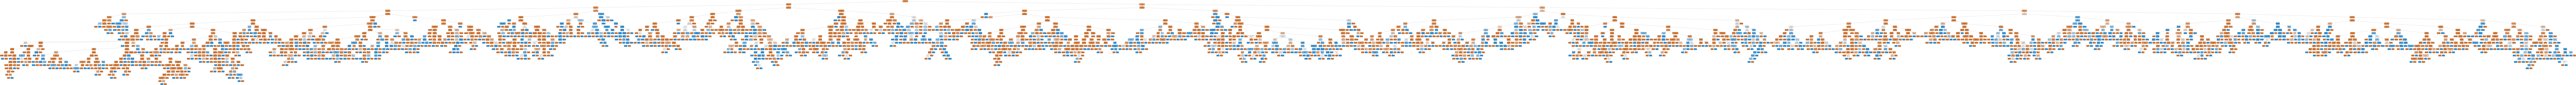

In [ ]:
estimator = forest.estimators_[0]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot',
                # feature_names = iris.feature_names,
                # class_names = iris.target_names,
                rounded = True, proportion = False,
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')